<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Performance_Experiments_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Experiments v3
From the v2 notebook I noticed yet another example of how learning can get really crazy when the learning rate is too high. But it's puzzling why the polynomial model would create quite the results it did.

So let's use that as an interesting example to test out some ideas about understanding these things. And also look into detail about what's happening with that particular problem.

Note that this notebook is focused on _performance_ from the point of view of _poor configuration_, rather than execution optimisation.

Ideas to try:
* Instead of just plotting loss at the end of each epoch, lets collect stats. eg: min, max, mean, last.
  * Note: for most of my polynomial training examples in the v2 notebook, I had one training step per epoch. So those plots were as accurate as you get and I won't get anything further with stats. However stats would be useful in more normal training scenarios to detect that level of noise that is otherwise averaged out.

* Attempt to identify exactly what's actually going on with the polynomial model. The learnings will probably be useful.

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import timeit
import math
from datetime import datetime

In [67]:
# First, some helper methods
# (timingcallback is defined later on)
def plot_history(model, history, timingcallback=None, **kwargs):
  y_pred = model(x_detailed)
  timings_quantity = kwargs.get('timings_quantity', 'epoch_per_step');

  loss = history.history['loss']
  times = None
  plt_count = 2

  if timingcallback is not None:
    plt_count += 1
    times = timingcallback.timings[timings_quantity]

  plt.figure(layout='constrained')

  plt.subplot(1,plt_count,1)
  plt.plot(x_detailed, y_detailed, color='blue', label="Truth")
  plt.scatter(x_train, y_train, color='blue', label="Training")
  plt.plot(x_detailed, y_pred, color='red', label="Prediction")
  plt.title('Result')
  plt.xlabel('x')
  plt.ylabel('y')

  plt.subplot(1,plt_count,2)
  plt.plot(loss)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.yscale('log')

  if times is not None:
    plt.subplot(1,plt_count,3)
    if timings_quantity == 'epoch_per_step' or timings_quantity == 'step':
      plt.plot(times * 1000)
      plt.ylabel(f"{timings_quantity} ms/step")
    else:
      plt.plot(times)
      plt.ylabel(f"{timings_quantity} secs")
    plt.title('Training Times')
    plt.xlabel('Epoch')

  plt.show()

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=None, display_total=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval
        self.display_total = display_total

    def set_params(self, params):
        self.epoch_count = params['epochs']
        if self.display_interval == None:
          self.display_interval = math.floor(self.epoch_count / self.display_total)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch + 1) % self.display_interval == 0) or epoch == self.epoch_count-1:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

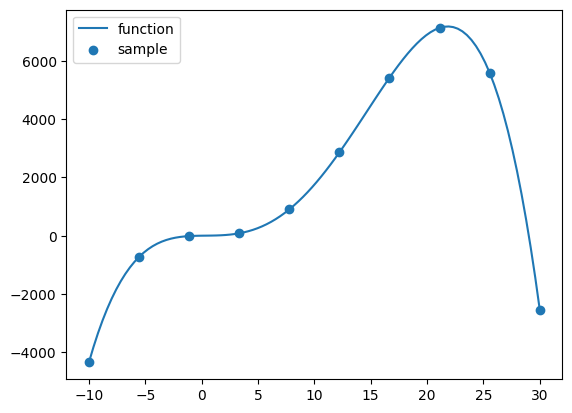

In [7]:
def fx(x):
    return 5*x - 3*x**2 + 3*x**3 - 0.1*x**4

x_train = np.array([np.linspace(-10.0, 30.0, 10)]).reshape(-1,1)
y_train = fx(x_train)
x_detailed = np.linspace(-10.0, 30.0, 100)
y_detailed = fx(x_detailed)
fig, ax = plt.subplots()
ax.plot(x_detailed, y_detailed, label='function')
ax.scatter(x_train, y_train, label='sample')
ax.legend()
fig.show()

In [5]:
# Fully TF-optimised implementation of Polynomial layer
class Polynomial(tf.keras.layers.Layer):
    def __init__(self, degree=4, regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.degree = tf.constant(degree, dtype=tf.int32)
        self.regularizer = tf.keras.regularizers.get(regularizer) # interprets named regularizers

    def build(self, input_shape):
        self.add_weight(
            shape=(self.degree+1,),
            initializer="zeros",
            regularizer=self.regularizer,
            trainable=True,
            name="amplitudes"
        )

    def call(self, inputs, training=False):
        sum=tf.zeros_like(inputs, dtype=inputs.dtype)  # copes with fact that the shape is not known when initially tracing, and with different batch sizes
        for i in tf.range(self.degree+1):
            p = tf.pow(inputs, tf.cast(i, inputs.dtype))         # a simple 'inputs ** i' produces the same results, the problem was that the datatype got mixed up
            sum += tf.multiply(p, tf.gather(self.weights[0], i))
        return sum

Let's start by observing the problem first hand. We'll see it a little bit with a 0.001 learning rate, and then use 0.01 to see it even worse.

Epoch  1000: loss: 6173347.0000  
Epoch  2000: loss: 2123721.7500  
Epoch  3000: loss: 541616.8750  
Epoch  4000: loss: 157558.2812  
Epoch  5000: loss: 107005.7734  
Epoch  6000: loss: 86172.2891  
Epoch  7000: loss: 64111.5234  
Epoch  8000: loss: 43244.2109  
Epoch  9000: loss: 26168.7305  
Epoch 10000: loss: 13844.7715  
Total training time: 82.90 secs


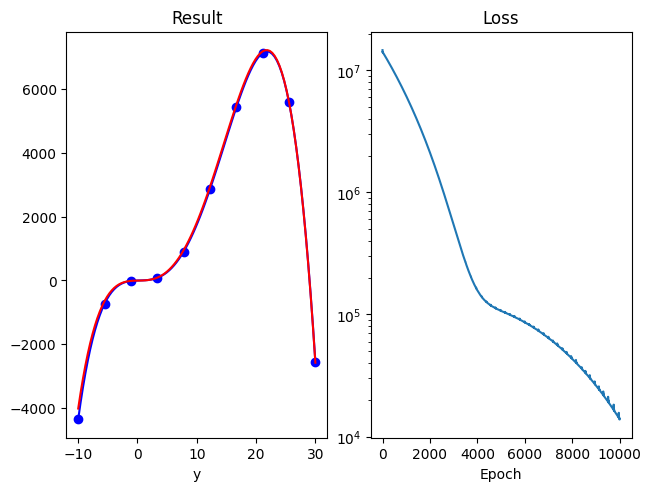

In [17]:
# learning rate 0.001
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
start = tf.timestamp()
history = model.fit(x_train, y_train, epochs=10000, batch_size=x_train.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start

print(f"Total training time: {duration.numpy():.2f} secs")
plot_history(model, history)

Epoch  1000: loss: 113452.9531  
Epoch  2000: loss: 42593.1055  
Epoch  3000: loss: 9752.1455  
Epoch  4000: loss: 1507.7340  
Epoch  5000: loss: 222.9744  
Epoch  6000: loss: 73.1352  
Epoch  7000: loss: 52.7987  
Epoch  8000: loss: 45.0290  
Epoch  9000: loss: 39.5343  
Epoch 10000: loss: 516.0960  
Total training time: 82.55 secs


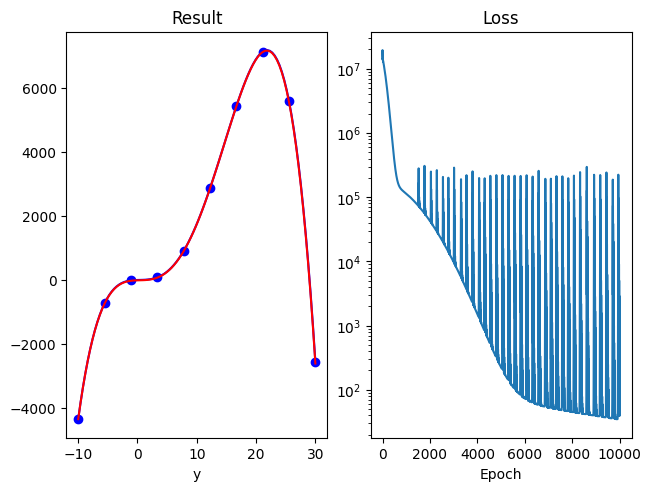

In [19]:
# Learning rate 0.01
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.01))
start = tf.timestamp()
history = model.fit(x_train, y_train, epochs=10000, batch_size=x_train.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start

print(f"Total training time: {duration.numpy():.2f} secs")
plot_history(model, history)

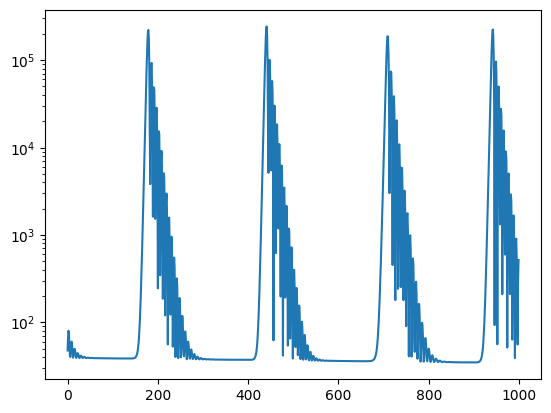

In [32]:
# Zooming into last 1000 epochs of second graph:
plt.plot(history.history['loss'][-1000:])
plt.yscale('log')
plt.show()

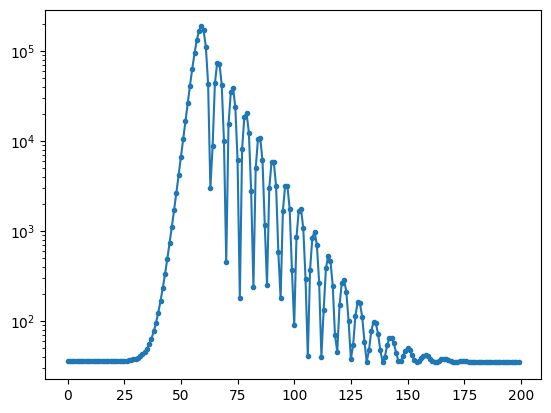

In [36]:
# And now looking at just one cycle of this periodic behaviour
part = history.history['loss'][-1000:]
plt.plot(part[650:850], marker='.')
plt.yscale('log')
plt.show()

In fact, already we're seeing something very peculiar. It looks like it's due to the optimizer's momentum mechanics. It's finding that the loss is stagnating, so it's ramping up its learning rate and then going in the wrong direction.

It might also be a numerical stability issue.

Let's try a few things:
* Usimple stochastic gradient descent, without any of the other fancyness.

Epoch 1/10
1/1 [==============================] - 1s 790ms/step - loss: 14643054.0000
Epoch 2/10
1/1 [==============================] - 0s 22ms/step - loss: 163646176.0000
Epoch 3/10
1/1 [==============================] - 0s 18ms/step - loss: 41736478720.0000
Epoch 4/10
1/1 [==============================] - 0s 17ms/step - loss: 11640055529472.0000
Epoch 5/10
1/1 [==============================] - 0s 12ms/step - loss: 3247431751827456.0000
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 905994488910970880.0000
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 252761573598913626112.0000
Epoch 8/10
1/1 [==============================] - 0s 12ms/step - loss: 70517444030160519036928.0000
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 19673512506529476354506752.0000
Epoch 10/10
1/1 [==============================] - 0s 10ms/step - loss: 5488672565890437205695922176.0000
Total training time: 1.19 secs


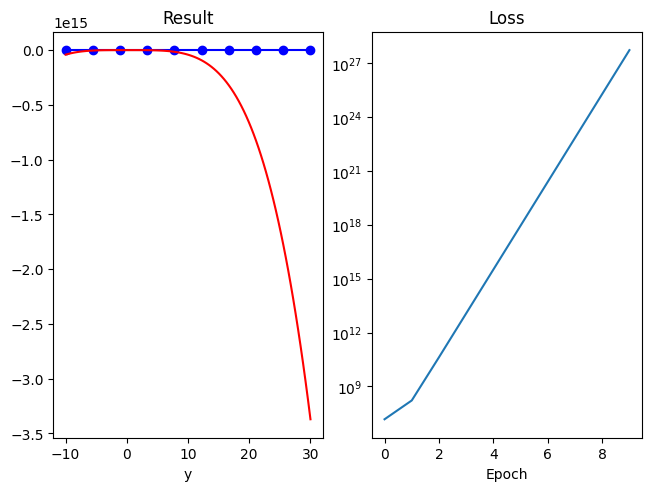

In [44]:
# However, I very quickly discovered that it goes immediately towards infinite loss, and only the very lowest learning rate was sufficient to reduce it a bit
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.SGD(learning_rate=1e-10))
start = tf.timestamp()
#history = model.fit(x_train, y_train, epochs=10000, batch_size=x_train.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
history = model.fit(x_train, y_train, epochs=10, batch_size=x_train.shape[0])
duration = tf.timestamp() - start

print(f"Total training time: {duration.numpy():.2f} secs")
plot_history(model, history)

In [45]:
model.get_weights()

[array([-7.2856733e+03, -1.9221125e+05, -5.2762240e+06, -1.4692394e+08,
        -4.1566868e+09], dtype=float32)]

Let's turn this into a custom training loop and take a closer look.

Tip: code available from here: https://www.tensorflow.org/guide/basic_training_loops

In [62]:
def train_step(model, x, y, learning_rate):
  with tf.GradientTape() as tape:
    y_pred = model(x)
    loss = tf.reduce_mean(tf.square(y_pred - y))  # MSE

  gradients = tape.gradient(loss, model.trainable_variables)
  for (variable, grad) in zip(model.trainable_variables, gradients):
    gradz = tf.gather(grad.values, grad.indices)
    variable.assign_sub(learning_rate * gradz)

  return (loss.numpy(),
    tf.gather(gradients[0].values, gradients[0].indices).numpy(),
    model.trainable_variables[0].numpy())

def train(model, x, y, epochs, learning_rate=0.01):
  print(f"Start:")
  print(f"  amplitudes: {model.trainable_variables[0].numpy()}")

  for epoch in range(epochs):
    loss, gradients, amplitudes = train_step(model, x, y, learning_rate)
    print(f"Epoch {epoch+1}: loss={loss:.4f}")
    print(f"  gradients:  {gradients}")
    print(f"  amplitudes: {amplitudes}")

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4)
])
model.compile(loss='mse')
train(model, x_train, y_train, 10, learning_rate=0.01)

Start:
  amplitudes: [0. 0. 0. 0. 0.]
Epoch 1: loss=14643054.0000
  gradients:  [-2.8682671e+03 -7.9402375e+04 -1.2126495e+06 -2.5343156e+07
 -4.3502419e+08]
  amplitudes: [2.8682671e+01 7.9402374e+02 1.2126495e+04 2.5343155e+05 4.3502420e+06]
Epoch 2: loss=1679921059671508273594368.0000
  gradients:  [1.3510132e+12 3.5642453e+13 9.7835691e+14 2.7243409e+16 7.7074480e+17]
  amplitudes: [-1.3510132e+10 -3.5642452e+11 -9.7835685e+12 -2.7243409e+14
 -7.7074477e+15]
Epoch 3: loss=inf
  gradients:  [-2.3915429e+21 -6.3093886e+22 -1.7319354e+24 -4.8228201e+25
 -1.3644443e+27]
  amplitudes: [2.3915429e+19 6.3093883e+20 1.7319353e+22 4.8228198e+23 1.3644442e+25]
Epoch 4: loss=inf
  gradients:  [4.2337320e+30 1.1169469e+32 3.0660336e+33 8.5378051e+34 2.4154664e+36]
  amplitudes: [-4.2337319e+28 -1.1169468e+30 -3.0660337e+31 -8.5378047e+32
 -2.4154664e+34]
Epoch 5: loss=inf
  gradients:  [-inf  nan -inf  nan -inf]
  amplitudes: [inf nan inf nan inf]
Epoch 6: loss=nan
  gradients:  [nan nan nan n

In [66]:
# Let's try with a much much much lower learning rate
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4)
])
model.compile(loss='mse')
train(model, x_train, y_train, 10, learning_rate=1e-11)

Start:
  amplitudes: [0. 0. 0. 0. 0.]
Epoch 1: loss=14643054.0000
  gradients:  [-2.8682671e+03 -7.9402375e+04 -1.2126495e+06 -2.5343156e+07
 -4.3502419e+08]
  amplitudes: [2.8682670e-08 7.9402372e-07 1.2126495e-05 2.5343156e-04 4.3502417e-03]
Epoch 2: loss=14424077.0000
  gradients:  [-1.5172539e+03 -4.3759926e+04 -2.3429275e+05  1.9002520e+06
  3.3572045e+08]
  amplitudes: [4.3855209e-08 1.2316229e-06 1.4469422e-05 2.3442904e-04 9.9303736e-04]
Epoch 3: loss=14293741.0000
  gradients:  [-2.5577830e+03 -7.1211359e+04 -9.8787112e+05 -1.9084530e+07
 -2.5797885e+08]
  amplitudes: [6.9433042e-08 1.9437366e-06 2.4348134e-05 4.2527434e-04 3.5728258e-03]
Epoch 4: loss=14216002.0000
  gradients:  [-1.7561237e+03 -5.0062008e+04 -4.0735200e+05 -2.9194710e+06
  1.9934368e+08]
  amplitudes: [8.6994277e-08 2.4443566e-06 2.8421653e-05 4.5446906e-04 1.5793890e-03]
Epoch 5: loss=14169470.0000
  gradients:  [-2.3734895e+03 -6.6349508e+04 -8.5447894e+05 -1.5370686e+07
 -1.5292880e+08]
  amplitudes: [1.1

**Learnings:**
* The polynomial model is just as hard to learn as the other complex curve things I was doing. It's a wonder that the Adam optimizer is able to cope so well with it. But somehow it mysteriously masks over all the problems that are so obviously exposed with pure SGD.
* **Fundamental problem**:
  * partial-differentiation assumes the weights are i.i.d., but that is absolutely not true in the polynomial case - with the weights having very complex interactions.
* Consequently, starting from amplitudes [0,0,0,0,0] (ie: $0 + 0x + 0x^2 + 0x^3 + 0x^4$), the algorithm treats each amplitude independently and calculates how much to change it to try to solve the entire problem using just that individual amplitude. The problem is that the gradients of higher-order parts are automatically much more than that of the others ($\frac{d}{dx}x^4 = 4x^3 > \frac{d}{dx}x^3 = 3x^2$ for all x >= 1)

**Next Steps**:
* I think this notebook deserves to be renamed as "Hard To Train v2", and I move on from it as far as the performance visualisations go.
* There's something interesting further to understand about how to solve this kind of problem. I expect that non-iid weight issues occur in all sorts of other scenarios. But how to solve it?

**Regularization:**
* There must be some kind of regularization or training tweak that could produce better results. It's just not clear what that would be if trying to come up with something generic.
* In this particular case, if doing it manually, I'd probably focus on the lowest orders and then work up. For example, get the baseline ($a_0x^0 = a_0$) correct first by assuming a flat line at baseline.
* Then I'd move onto the first-order polynomial ($a_0 + a_1x$), and refit.
* And then onto second-order polynomial ($a_0 + a_1x + a_2x^2$).
* The interesting thing is that the first guesses on those lower-order polynomials will still be way off.

In [69]:
# In this particular case, the flat-line fit would be:
np.mean(y_train)

1434.1335162322805

Epoch 1/10
1/1 [==============================] - 1s 547ms/step - loss: 14643053.0000
Epoch 2/10
1/1 [==============================] - 0s 11ms/step - loss: 14643054.0000
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 14643054.0000
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 14643054.0000
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 14643054.0000
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 14643053.0000
Epoch 7/10
1/1 [==============================] - 0s 12ms/step - loss: 14643054.0000
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 14643054.0000
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 14643054.0000
Epoch 10/10
1/1 [==============================] - 0s 11ms/step - loss: 14643053.0000
Total training time: 0.79 secs


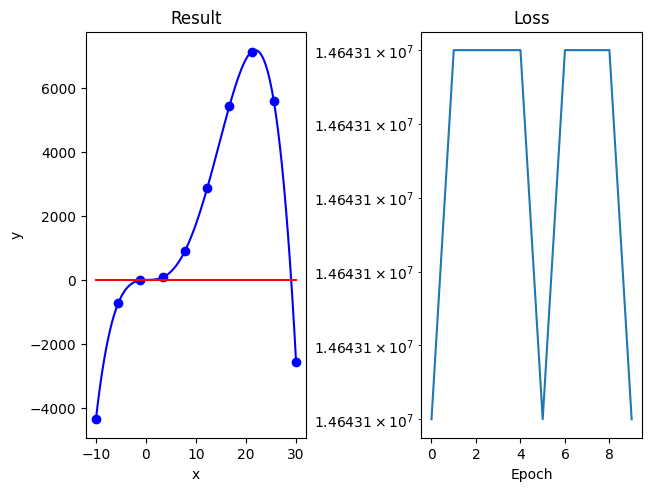

In [70]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=0)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.SGD(learning_rate=1e-10))
start = tf.timestamp()
history = model.fit(x_train, y_train, epochs=10, batch_size=x_train.shape[0])
duration = tf.timestamp() - start

print(f"Total training time: {duration.numpy():.2f} secs")
plot_history(model, history)

In [71]:
inherited_amplitudes = model.get_weights()[0]
inherited_amplitudes

array([2.868267e-06], dtype=float32)

Weights: [array([2.868267e-06, 0.000000e+00], dtype=float32)]
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 14643053.0000
Epoch 2/10
1/1 [==============================] - 0s 28ms/step - loss: 9992565.0000
Epoch 3/10
1/1 [==============================] - 0s 32ms/step - loss: 8950725.0000
Epoch 4/10
1/1 [==============================] - 0s 22ms/step - loss: 8717309.0000
Epoch 5/10
1/1 [==============================] - 0s 19ms/step - loss: 8664998.0000
Epoch 6/10
1/1 [==============================] - 0s 20ms/step - loss: 8653261.0000
Epoch 7/10
1/1 [==============================] - 0s 17ms/step - loss: 8650611.0000
Epoch 8/10
1/1 [==============================] - 0s 26ms/step - loss: 8650000.0000
Epoch 9/10
1/1 [==============================] - 0s 21ms/step - loss: 8649842.0000
Epoch 10/10
1/1 [==============================] - 0s 25ms/step - loss: 8649789.0000
Total training time: 2.02 secs


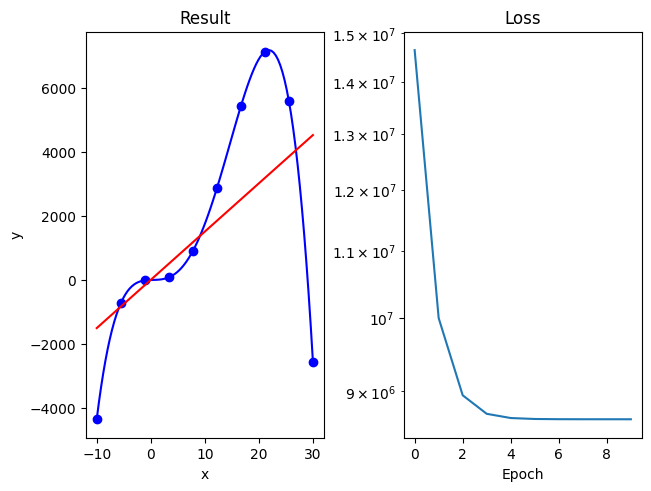

In [92]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=1)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3))
model.trainable_variables[0].assign(np.concatenate((inherited_amplitudes, [0])))
print(f"Weights: {model.get_weights()}")
start = tf.timestamp()
history = model.fit(x_train, y_train, epochs=10, batch_size=x_train.shape[0])
duration = tf.timestamp() - start

print(f"Total training time: {duration.numpy():.2f} secs")
plot_history(model, history)

In [93]:
inherited_amplitudes = model.get_weights()[0]
inherited_amplitudes

array([  4.1701427, 150.72127  ], dtype=float32)

Weights: [array([  4.1701427, 150.72127  ,   0.       ], dtype=float32)]
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 8649758.0000
Epoch 2/10
1/1 [==============================] - 0s 16ms/step - loss: 8380273.5000
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 8251848.0000
Epoch 4/10
1/1 [==============================] - 0s 13ms/step - loss: 8190521.0000
Epoch 5/10
1/1 [==============================] - 0s 15ms/step - loss: 8161106.5000
Epoch 6/10
1/1 [==============================] - 0s 18ms/step - loss: 8146872.0000
Epoch 7/10
1/1 [==============================] - 0s 12ms/step - loss: 8139860.0000
Epoch 8/10
1/1 [==============================] - 0s 18ms/step - loss: 8136282.5000
Epoch 9/10
1/1 [==============================] - 0s 13ms/step - loss: 8134337.5000
Epoch 10/10
1/1 [==============================] - 0s 15ms/step - loss: 8133169.5000
Total training time: 1.64 secs


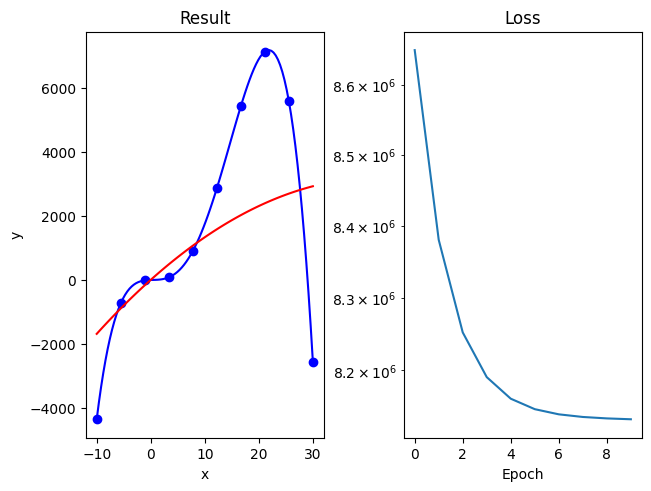

In [100]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=2)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6))  ## learning rate 1e-5 or greater is too high
model.trainable_variables[0].assign(np.concatenate((inherited_amplitudes, [0])))
print(f"Weights: {model.get_weights()}")
start = tf.timestamp()
history = model.fit(x_train, y_train, epochs=10, batch_size=x_train.shape[0])
duration = tf.timestamp() - start

print(f"Total training time: {duration.numpy():.2f} secs")
plot_history(model, history)


In [101]:
inherited_amplitudes = model.get_weights()[0]
inherited_amplitudes

array([  4.175159 , 150.86865  ,  -1.7810415], dtype=float32)

Weights: [array([  4.175159 , 150.86865  ,  -1.7810415,   0.       ], dtype=float32)]
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 8132373.0000
Epoch 2/10
1/1 [==============================] - 0s 14ms/step - loss: 8090155.0000
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 8064757.0000
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 8049469.0000
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 8040257.0000
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 8034697.0000
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 8031333.0000
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 8029288.0000
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 8028035.0000
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 8027261.0000
Total training time: 1.70 secs


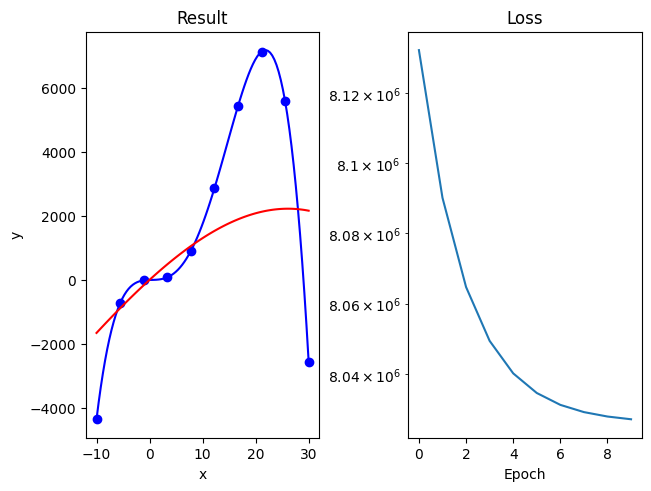

In [111]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=3)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.SGD(learning_rate=1e-9))  ## learning rate 1e-8 or greater is too high
model.trainable_variables[0].assign(np.concatenate((inherited_amplitudes, [0])))
print(f"Weights: {model.get_weights()}")
start = tf.timestamp()
history = model.fit(x_train, y_train, epochs=10, batch_size=x_train.shape[0])
duration = tf.timestamp() - start

print(f"Total training time: {duration.numpy():.2f} secs")
plot_history(model, history)

Weights: [array([0., 0., 0., 0.], dtype=float32)]
Epoch     4: loss: 13521626.0000  
Epoch     8: loss: 13250882.0000  
Epoch    12: loss: 13215246.0000  
Epoch    16: loss: 13210298.0000  
Epoch    20: loss: 13209354.0000  
Epoch    24: loss: 13208934.0000  
Epoch    28: loss: 13208581.0000  
Epoch    32: loss: 13208237.0000  
Epoch    36: loss: 13207894.0000  
Epoch    40: loss: 13207553.0000  
Total training time: 1.28 secs


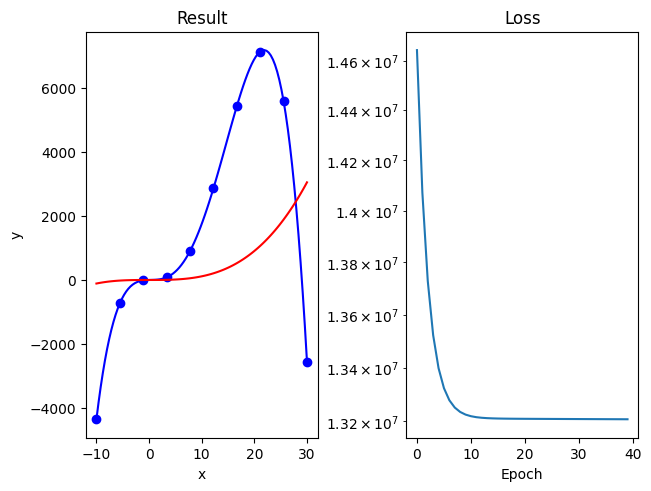

In [114]:
# In contrast, let's just train the same thing from scratch with the same number of total epochs
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=3)
])
model.compile(loss='mse', optimizer = tf.keras.optimizers.SGD(learning_rate=1e-9))  ## learning rate 1e-7 or greater is too high
print(f"Weights: {model.get_weights()}")
start = tf.timestamp()
history = model.fit(x_train, y_train, epochs=40, batch_size=x_train.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start

print(f"Total training time: {duration.numpy():.2f} secs")
plot_history(model, history)

Conclusion: that ain't helping much.

Let's try something different, let's heavily penalise the higher orders by making their learning rate exponentially less than the lower orders.

In [120]:
np.ones((5,1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [121]:
np.arange(0,4+1).reshape(-1,1)

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [123]:
tf.pow(np.ones((5,1)) * 0.1, np.arange(0,4+1).reshape(-1,1))

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[1.e+00],
       [1.e-01],
       [1.e-02],
       [1.e-03],
       [1.e-04]])>

In [139]:
degree=4
learning_rates = (np.ones((5,1)) * 0.1) ** (np.arange(0,degree+1).reshape(-1,1) * 2)
learning_rates = learning_rates.reshape(-1)
def train_step(model, x, y, learning_rate):
  with tf.GradientTape() as tape:
    y_pred = model(x)
    loss = tf.reduce_mean(tf.square(y_pred - y))  # MSE

  gradients = tape.gradient(loss, model.trainable_variables)
  updates = []
  for (variable, grad) in zip(model.trainable_variables, gradients):
    gradz = tf.gather(grad.values, grad.indices)
    #print(f"Graz: {gradz}")
    #print(f"rates: {learning_rates}")
    #print(f"updates: {learning_rate * learning_rates * gradz}")
    updates = learning_rate * learning_rates * gradz
    variable.assign_sub(updates)

  return (loss.numpy(),
    tf.gather(gradients[0].values, gradients[0].indices).numpy(),
    model.trainable_variables[0].numpy(),
    updates)

def train(model, x, y, epochs, learning_rate=0.01):
  print(f"Start:")
  print(f"  amplitudes: {model.trainable_variables[0].numpy()}")

  for epoch in range(epochs):
    loss, gradients, amplitudes, updates = train_step(model, x, y, learning_rate)
    print(f"Epoch {epoch+1}: loss={loss:.4f}")
    #print(f"  gradients:  {gradients}")
    #print(f"  amplitudes: {amplitudes}")
    print(f"  updates: {updates}")

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    Polynomial(name="poly", degree=4)
])
model.compile(loss='mse')
train(model, x_train, y_train, 100, learning_rate=0.001)

Start:
  amplitudes: [0. 0. 0. 0. 0.]
Epoch 1: loss=14643054.0000
  updates; [-2.8682673  -0.79402375 -0.12126495 -0.02534316 -0.00435024]
Epoch 2: loss=14510587.0000
  updates; [-1.1363655  -0.34082252  0.00192522  0.00880197  0.00527108]
Epoch 3: loss=14381483.0000
  updates; [-2.8653219  -0.79722196 -0.12316255 -0.02601124 -0.00457163]
Epoch 4: loss=14255770.0000
  updates; [-1.0558944  -0.32361218  0.00560451  0.00968382  0.00548738]
Epoch 5: loss=14133488.0000
  updates; [-2.8647032  -0.8009672  -0.12519698 -0.02671543 -0.00480279]
Epoch 6: loss=14014678.0000
  updates; [-0.97420776 -0.30601847  0.00940092  0.01060007  0.00571381]
Epoch 7: loss=13899382.0000
  updates; [-2.8664837  -0.80527943 -0.12737377 -0.02745729 -0.00504418]
Epoch 8: loss=13787651.0000
  updates; [-0.89121693 -0.28801882  0.01332044  0.01155238  0.00595082]
Epoch 9: loss=13679534.0000
  updates; [-2.87074    -0.8101796  -0.12969878 -0.02823848 -0.00529626]
Epoch 10: loss=13575085.0000
  updates; [-0.8068294  